In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from glob import glob
import configparser

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

In [5]:
from scipy.optimize import curve_fit, minimize
import astropy.units as u

In [6]:
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.spectra import convolve as lsc
from astropy.units import Quantity
import numpy.ma as ma
import math
import scipy.special as sp

In [11]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from astropy.coordinates import Angle

In [7]:
plt.style.use('../figures.mplstyle')

In [76]:
def get_datapaths(galname,logcube=True, maps=True, mcmc=True, config=True):
    global fig_out 
        
    outdict = {}
    repodir = "/Users/apitts4030/Repo/NaI_analysis/"
    datadir = os.path.join(repodir, f"data/{galname}")
    
    if config:
        configdir = os.path.join(datadir, 'config')
        configdirfils = glob(os.path.join(configdir, "**", "*.ini"), recursive=True)
        if len(configdirfils)>1:
            #raise ValueError(f"{configdir} has more than one config file:\n {configdirfils}")
            print(f"{configdir} has more than one config file:\n {configdirfils}")
            print(f"Defaulting to {configdirfils[0]}")
        configfil = configdirfils[0]
        outdict['config'] = [configfil]
        
    if logcube or maps:
        cubedir = os.path.join(datadir, 'cube')
        cubedirfils = glob(os.path.join(cubedir, "**", "*.fits"), recursive=True)
        cubefil = None
        mapfil = None
        for fil in cubedirfils:
            if 'LOGCUBE' in fil and 'BETA-CORR' in fil:
                cubefil = fil
        
            if 'MAPS' in fil and 'BETA-CORR' in fil:
                mapfil = fil
        if logcube:
            outdict['logcube'] = [cubefil]
        if maps:
            outdict['maps'] = [mapfil]
    if mcmc:
        mcmcdir = os.path.join(datadir, 'mcmc')
        mcmcfils = glob(os.path.join(mcmcdir, "**", "*.fits"), recursive=True)
        outdict['mcmc'] = mcmcfils

    fig_out = f"paper-plots/{galname}/"
    print(f"Setting figure output path to {fig_out}")
    if not os.path.exists(fig_out):
        print(f"Making Directory {fig_out}")
        os.mkdir(fig_out)
    return outdict

# Fake absorption line model

In [44]:
lsf_config = "../../mangadap_muse/MUSE_cubes/LSF-Config_MUSE_WFM"
lsf = np.genfromtxt(lsf_config, names=('wavelength','fwhm'))

In [208]:
def transitions():

    lamblu0 = 5891.5833
    lamred0 = 5897.5581

    #lamfblu0 = 3718.17822063
    #lamfred0 = 1875.4234758
    fblu0 = 6.50e-01
    fred0 = 3.24e-01
    
    lamfblu0 = lamblu0 * fblu0
    lamfred0 = lamred0 * fred0
    
    return {'lamblu0':lamblu0, 'lamred0':lamred0, 'lamfblu0':lamfblu0, 'lamfred0':lamfred0}

def continuum_normalize(wave, flux, err):
    transinfo = transitions()
    regionb = transinfo['lamblu0'] - 20, transinfo['lamblu0'] - 10
    regionr = transinfo['lamred0'] + 10, transinfo['lamred0'] + 20

    indb = np.where((wave>=regionb[0]) & (wave<=regionb[1]))[0]
    indr = np.where((wave>=regionr[0]) & (wave<=regionr[1]))[0]
    inds = np.concatenate((indb,indr))

    fullregion = slice(inds[0],inds[-1])

    fitflx = flux[inds]
    fitwv = wave[inds]
    w = abs(fitflx - np.median(fitflx)) <= np.std(fitflx)

    p = np.polyfit(fitwv[w], fitflx[w], deg=1)
    continuum = np.polyval(p, wave[fullregion])

    
    return wave[fullregion], flux[fullregion] / continuum, err[fullregion] / continuum


def lnlike(theta, wave, flux, err, lsf):
    _,flx_model = model_NaI(theta, lsf, wave)
    return -0.5 * np.sum(((flux - flx_model)/err)**2 - np.log(2 * np.pi / (err)**2))



def model_NaI(theta, lsf, newwv):

    # First, get info on transitions
    sol = 2.998e5    # km/s
    transinfo = transitions()
    velratio = 1.0 + (transinfo['lamblu0'] - transinfo['lamred0'])/transinfo['lamred0']
    dmwv = 0.1   # in Angstroms
    
    lamred, logN, bD, Cf = theta

    N = 10.0**logN
    lamblu = lamred * velratio
    taured0 = N * 1.497e-15 * transinfo['lamfred0'] / bD
    taublu0 = N * 1.497e-15 * transinfo['lamfblu0'] / bD

    wv_unit = u.AA
    modwave = np.arange(5870.0,5920.0,dmwv)
    modwave_u = u.Quantity(modwave,unit=wv_unit)

    
    exp_red = -1.0 * (modwave - lamred)**2 / (lamred * bD / sol)**2
    exp_blu = -1.0 * (modwave - lamblu)**2 / (lamblu * bD / sol)**2

    taured = taured0 * np.exp(exp_red)
    taublu = taublu0 * np.exp(exp_blu)

    ## Unsmoothed model profile
    model_NaI = 1.0 - Cf + (Cf * np.exp(-1.0*(taublu + taured)))
    xspec = XSpectrum1D.from_tuple((modwave,model_NaI))
    
    ## Now smooth with a Gaussian resolution element
    ## Can try XSpectrum1D.gauss_smooth (couldn't get this to work)

    # FWHM resolution in pix
    midwv = (transinfo['lamblu0'] + transinfo['lamred0']) / 2.0
    #wvres = midwv * velres / sol
    wvres = lsf['fwhm'][np.argmin(abs(midwv - lsf['wavelength']))]
    pxres = wvres / dmwv

   
    smxspec = xspec.gauss_smooth(pxres)
    
    
    ## Now rebin to match pixel size of observations
    ## Can try XSpectrum1D.rebin, need to input observed wavelength array
    #wv_unit = u.AA
    uwave = u.Quantity(newwv,unit=wv_unit)
    #uwave = np.array(newwv)
    # Rebinned spectrum
    rbsmxspec = smxspec.rebin(uwave)
    
    modwv = rbsmxspec.wavelength.value
    modflx = rbsmxspec.flux.value
    
    #return {'modwv':modwv, 'modflx':modflx}
    return modwv, modflx


def lnprior(theta):

    #print('lnprior theta: ',theta)
    lamred, logN, bD, Cf = theta

    sol = 2.998e5    # km/s
    transinfo = transitions()
    #vlim = 400.0     # km/s
    vlim = 400.0
    lamlim1 = -1.0 * (vlim * transinfo['lamred0'] / sol) + transinfo['lamred0']
    lamlim2 = (vlim * transinfo['lamred0'] / sol) + transinfo['lamred0']

    #logNlim1 = 10.0
    #logNlim2 = 15.0
    #logNlim1 = 14.0
    #logNlim1 = 13.5
    #logNlim2 = 16.5
    #logNlim1 = 14.1
    logNlim1 = 10.0
    logNlim2 = 18.0
   
    bDlim1 = 10.0
    bDlim2 = 200.0
    #bDlim2 = 500.0
   
    Cflim1 = 0.0
    Cflim2 = 1.0
   
    #if -5.0 < m < 5.0 and -10.0 < b < 10.0 and -10.0 < lnf < 10.0:
    if lamlim1 < lamred < lamlim2 and logNlim1 < logN < logNlim2 and bDlim1 < bD < bDlim2 and Cflim1 < Cf < Cflim2:
        return 0.0
    return -np.inf

def lnprob(theta, wave, flux, err, lsf):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, wave, flux, err, lsf)

In [296]:
flux = cube['FLUX'].data
wave = cube['WAVE'].data
model = cube['MODEL'].data
ivar = cube['IVAR'].data
binid = cube['BINID'].data[0]

stellarvel = Map['STELLAR_VEL'].data
sigma = 1/np.sqrt(ivar)

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_8175/1251045125.py:8: RuntimeWarning: divide by zero encountered in divide
  sigma = 1/np.sqrt(ivar)


6648


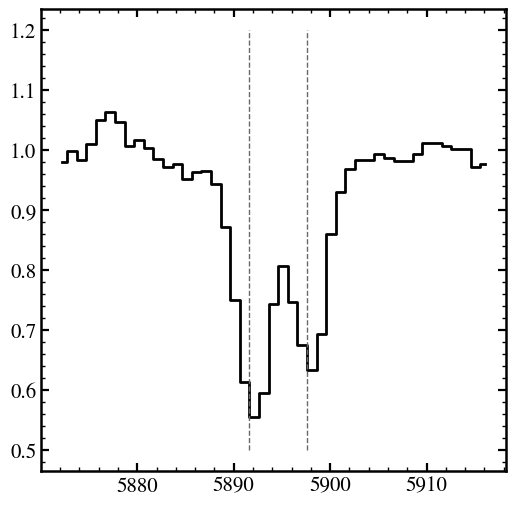

In [567]:
ID = np.random.randint(1,high=np.unique(binid).max())
#ID = 6974
print(ID)
inds = np.where(binid==ID)
indy=inds[0][0]
indx=inds[1][0]
flux1 = flux[:,indy,indx]
sig1 = sigma[:,indy,indx]
model1 = model[:,indy,indx]
sv = stellarvel[indy,indx]

c = 2.998e5
z = (sv * (1+redshift))/c + redshift

normwave, normflx, normerr = continuum_normalize(wave/(1+z), flux1, sig1)
normwave, normmodel, _ = continuum_normalize(wave/(1+z), model1, sig1)
plt.plot(normwave,normflx,drawstyle='steps-mid',color='k')
plt.vlines([tinfo['lamblu0'], tinfo['lamred0']], 0.5, 1.2, linestyles='dashed', linewidths=1, colors='dimgray')

In [572]:
theta_guess = (5898, 14, 77, 0.3)
modwv, modflx = model_NaI(theta_guess, lsf, normwave)

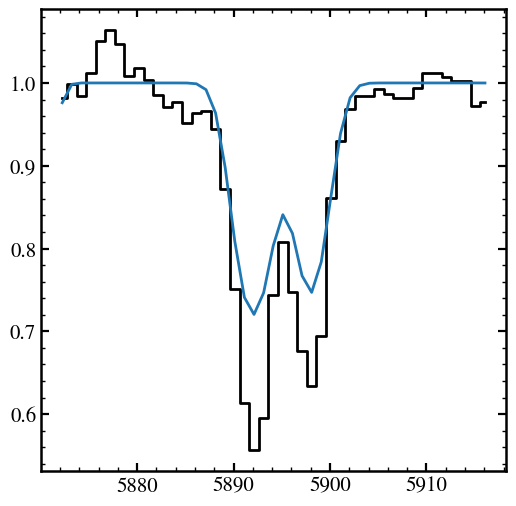

In [573]:
plt.plot(normwave,normflx,drawstyle='steps-mid',color='k')
plt.plot(modwv,modflx)

In [574]:
ndim = 4
nwalkers = 100
startpoint = [theta_guess[0],theta_guess[1],theta_guess[2],theta_guess[3]]
pos = [startpoint + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(normwave,normflx,normerr,lsf))

In [575]:
sampler.run_mcmc(pos, 1000, rstate0=np.random.get_state())

State([[5.89798353e+03 1.37131507e+01 7.86469284e+01 5.13222772e-01]
 [5.89796824e+03 1.38358405e+01 7.29244303e+01 4.97219419e-01]
 [5.89801622e+03 1.37712431e+01 7.39047724e+01 5.07262619e-01]
 [5.89799816e+03 1.37811720e+01 7.51501324e+01 5.06374260e-01]
 [5.89800427e+03 1.36827681e+01 7.66922195e+01 5.45911836e-01]
 [5.89805979e+03 1.37159549e+01 7.38948108e+01 5.33146595e-01]
 [5.89797323e+03 1.37361676e+01 7.48821734e+01 5.31426645e-01]
 [5.89795805e+03 1.37552721e+01 7.65243602e+01 5.04778564e-01]
 [5.89802720e+03 1.37673766e+01 7.29848833e+01 5.15145966e-01]
 [5.89799679e+03 1.38271185e+01 7.44076069e+01 4.95052494e-01]
 [5.89799537e+03 1.38172075e+01 7.40403142e+01 4.94739940e-01]
 [5.89802724e+03 1.37742580e+01 7.38508597e+01 5.12230386e-01]
 [5.89803232e+03 1.37549614e+01 7.35174086e+01 5.20118259e-01]
 [5.89793640e+03 1.37435862e+01 7.74358112e+01 5.04063149e-01]
 [5.89797998e+03 1.38122739e+01 7.41147278e+01 5.06013157e-01]
 [5.89803720e+03 1.38232198e+01 7.02684932e+01 5.

In [576]:
samples_burnin = sampler.chain[:,900,:].reshape((-1,ndim))
theta_mcmc = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples_burnin, [16, 50, 84], axis=0))))

In [601]:
samples = sampler.get_chain(flat=True)

In [577]:
theta_mcmc

[(5898.010504627939, 0.033154173867842474, 0.03256814842916356),
 (13.763494957140516, 0.048466563377994376, 0.03472845127218882),
 (74.91546385022534, 3.072910459567183, 2.523072544370436),
 (0.5119067597380795, 0.013279599215045623, 0.016640492661595785)]

In [578]:
normwave.size

45

In [615]:
theta = (theta_mcmc[0][0],theta_mcmc[1][0],theta_mcmc[2][0],theta_mcmc[3][0])

#inputwave = normwave
inputwave = np.linspace(normwave.min(), normwave.max(), int((normwave.max() - normwave.min())*2))
modwave, modflux = model_NaI(theta, lsf, inputwave)

In [580]:
tinfo = transitions()

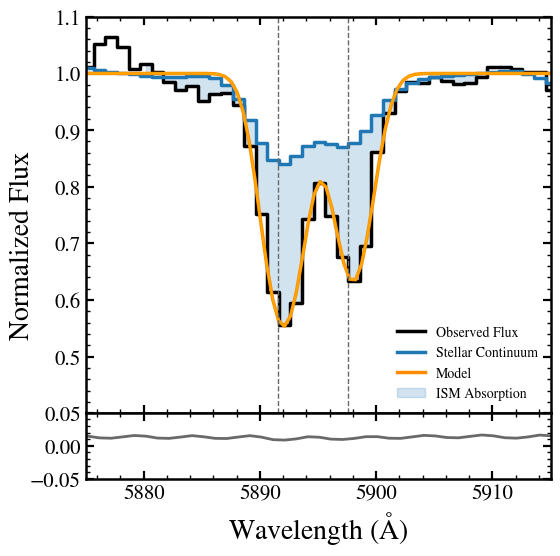

In [616]:
fig, (ax, ax2) = plt.subplots(2,sharex=True, gridspec_kw={'height_ratios': [6, 1]})

color='k'
ax.plot(normwave,normflx,drawstyle='steps-mid',color=color,linewidth=2.5, label='Observed Flux')

#color=[0.21176470588235294, 0.12941176470588237, 0.24313725490196078] #dark purple
color='tab:blue'
ax.plot(normwave,normmodel,drawstyle='steps-mid',color=color,linewidth=2.5, label='Stellar Continuum')

color='darkorange'
#color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
ax.plot(modwave, modflux, color=color, label='Model', linewidth=2.5)

color='orange'
#color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
ax.plot(modwave, modflux, color=color, linewidth=1.5)

ax.plot(normwave,normerr,color='dimgray')


window = (normwave >= 5880) & (normwave <= 5910)
#color=[0.3333333333333333, 0.28627450980392155, 0.44313725490196076] # dark lavender
color='tab:blue'
ax.fill_between(normwave,normmodel,normflx, window, color=color, alpha=0.2, step="mid", label='ISM Absorption')

ax.vlines([tinfo['lamblu0'], tinfo['lamred0']], 0.4, 1.2, linestyles='dashed', linewidths=1, colors='dimgray')


#ax.set_ylabel('Normalized Flux')
ax.set_xlim(5875,5915)
ax.set_ylim(0.401,1.1)

ax.legend(frameon=False, loc='lower right')

ax2.plot(normwave,normerr,color='dimgray')
ax2.set_ylim(-0.05,0.05)
ax2.set_yticks([-0.05,0,0.05])
ax2.set_xlabel(r'Wavelength $\left( \mathrm{\AA} \right)$')


fig.text(0.02,0.5,'Normalized Flux',va='center',rotation='vertical', ha='center',fontsize=20)
fig.subplots_adjust(hspace=0)
plt.savefig('paper-plots/NGC4030/NaD_model.pdf')

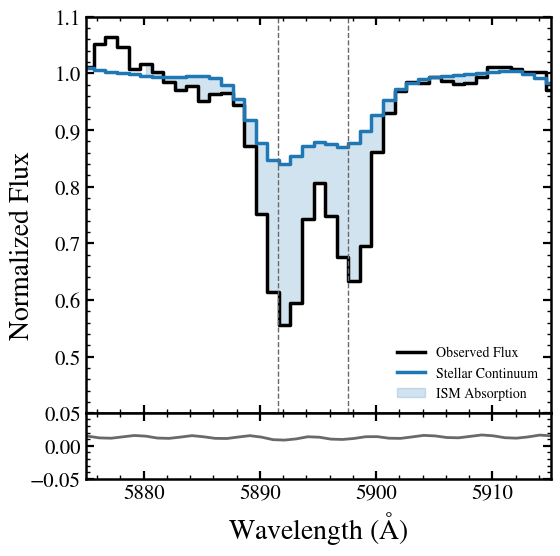

In [617]:
fig, (ax, ax2) = plt.subplots(2,sharex=True, gridspec_kw={'height_ratios': [6, 1]})

color='k'
ax.plot(normwave,normflx,drawstyle='steps-mid',color=color,linewidth=2.5, label='Observed Flux')

#color=[0.21176470588235294, 0.12941176470588237, 0.24313725490196078] #dark purple
color='tab:blue'
ax.plot(normwave,normmodel,drawstyle='steps-mid',color=color,linewidth=2.5, label='Stellar Continuum')

#color='darkorange'
#color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
#ax.plot(modwave, modflux, color=color, label='Model', linewidth=2.5)

#color='orange'
#color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
#ax.plot(modwave, modflux, color=color, linewidth=1.5)

ax.plot(normwave,normerr,color='dimgray')


window = (normwave >= 5880) & (normwave <= 5910)
#color=[0.3333333333333333, 0.28627450980392155, 0.44313725490196076] # dark lavender
color='tab:blue'
ax.fill_between(normwave,normmodel,normflx, window, color=color, alpha=0.2, step="mid", label='ISM Absorption')

ax.vlines([tinfo['lamblu0'], tinfo['lamred0']], 0.4, 1.2, linestyles='dashed', linewidths=1, colors='dimgray')


#ax.set_ylabel('Normalized Flux')
ax.set_xlim(5875,5915)
ax.set_ylim(0.401,1.1)

ax.legend(frameon=False, loc='lower right')

ax2.plot(normwave,normerr,color='dimgray')
ax2.set_ylim(-0.05,0.05)
ax2.set_yticks([-0.05,0,0.05])
ax2.set_xlabel(r'Wavelength $\left( \mathrm{\AA} \right)$')


fig.text(0.02,0.5,'Normalized Flux',va='center',rotation='vertical', ha='center',fontsize=20)
fig.subplots_adjust(hspace=0)
plt.savefig('paper-plots/NGC4030/NaD_model_no_fit.pdf')

In [604]:
import imageio

In [614]:
frames = []

for i,sample in enumerate(samples):

    if i>100:
        if i%1000 != 0:
            continue

    fig, (ax, ax2) = plt.subplots(2,sharex=True, gridspec_kw={'height_ratios': [6, 1]}, dpi=500)
    

    
    theta = (sample[0],sample[1],sample[2],sample[3])

    inputwave = np.linspace(normwave.min(), normwave.max(), int((normwave.max() - normwave.min())*2))
    modwave, modflux = model_NaI(theta, lsf, inputwave)

    color='k'
    ax.plot(normwave,normflx,drawstyle='steps-mid',color=color,linewidth=2.5, label='Observed Flux')
    
    #color=[0.21176470588235294, 0.12941176470588237, 0.24313725490196078] #dark purple
    color='tab:blue'
    ax.plot(normwave,normmodel,drawstyle='steps-mid',color=color,linewidth=2.5, label='Stellar Continuum')
    
    color='darkorange'
    #color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
    ax.plot(modwave, modflux, color=color, label='Model', linewidth=2.5)
    
    color='orange'
    #color=[0.5411764705882353, 0.7764705882352941, 0.8156862745098039]
    ax.plot(modwave, modflux, color=color, linewidth=1.5)
    
    ax.plot(normwave,normerr,color='dimgray')
    
    
    window = (normwave >= 5880) & (normwave <= 5910)
    #color=[0.3333333333333333, 0.28627450980392155, 0.44313725490196076] # dark lavender
    color='tab:blue'
    ax.fill_between(normwave,normmodel,normflx, window, color=color, alpha=0.2, step="mid", label='ISM Absorption')

    ax.vlines([tinfo['lamblu0'], tinfo['lamred0']], 0.4, 1.2, linestyles='dashed', linewidths=1, colors='dimgray')
    
    ax.set_xlim(5875,5915)
    ax.set_ylim(0.401,1.1)
    
    ax.legend(frameon=False, loc='lower right')
    
    ax2.plot(normwave,normerr,color='dimgray')
    ax2.set_ylim(-0.05,0.05)
    ax2.set_yticks([-0.05,0,0.05])
    ax2.set_xlabel(r'Wavelength $\left( \mathrm{\AA} \right)$')
    
    
    fig.text(0.02,0.5,'Normalized Flux',va='center',rotation='vertical', ha='center',fontsize=20)
    fig.subplots_adjust(hspace=0)
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    frames.append(image)
    
    # Close the figure to avoid displaying it
    plt.close(fig)

imageio.mimsave('paper-plots/NGC4030/emcee_fitting.gif', frames, fps=10, loop=0)

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_8175/1242309316.py:58: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


In [641]:
lamreds = sampler.chain[:,900,:]

In [648]:
lamreds = sampler.get_chain(flat=True)[:,0]

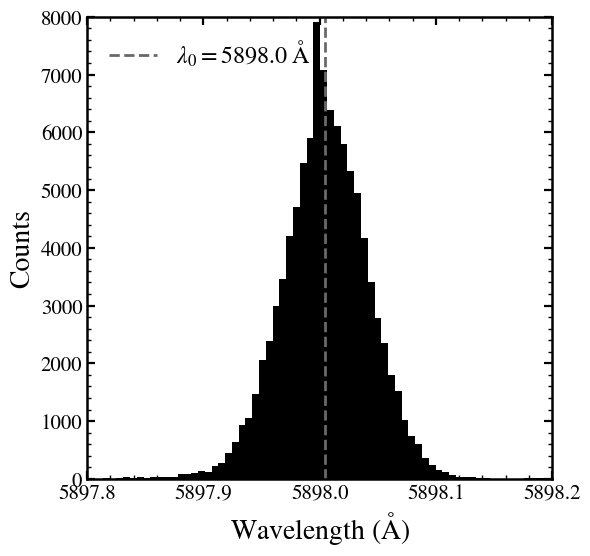

In [665]:
fig, ax = plt.subplots(1)
ax.hist(lamreds,bins=100,color='k')
ax.set_xlabel(r'Wavelength $\left(\mathrm{\AA}\right)$')
ax.set_ylabel('Counts')
string = r"\mathrm{\AA}"
ax.vlines(np.median(lamreds), ymin=0, ymax=9000, linestyles='dashed', colors='dimgray', label=rf"$\lambda_0 = {np.median(lamreds):.1f}\ {string} $")
ax.legend(frameon=False,fontsize='xx-large', loc='upper left')
#ax.text(0.6, 0.8,, transform=ax.transAxes, fontsize='x-large')
ax.set_ylim(0, 8000)
ax.set_xlim(5897.8, 5898.2)
fig.savefig('paper-plots/NGC4030/lambda_ppd.pdf',bbox_inches='tight')
plt.show()

In [667]:
import corner

In [669]:
samples[0]

array([5.89799985e+03, 1.39999562e+01, 7.70001129e+01, 3.00175078e-01])

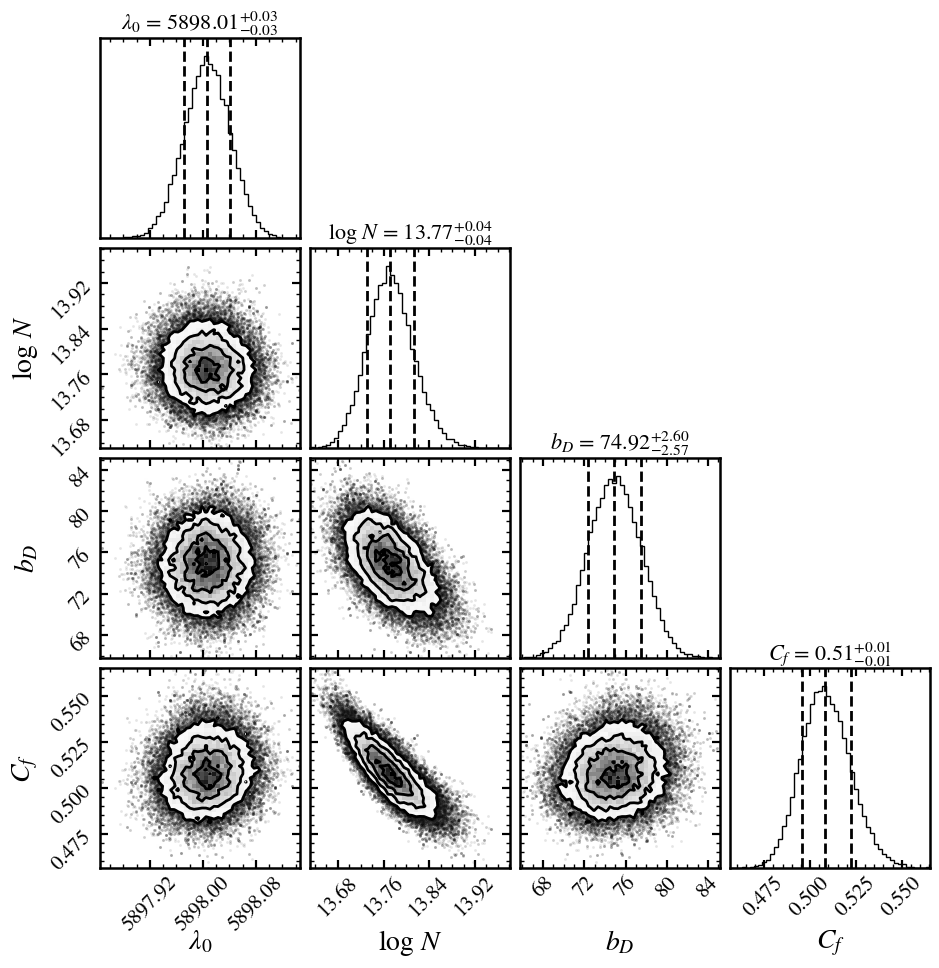

In [676]:
flat_samples = sampler.get_chain(discard = 100, flat=True)

labels = [r"$\lambda_0$", r"$\mathrm{log}\ N$", r"$b_D$", r"$C_f$"]
fig = corner.corner(flat_samples, labels=labels, bins=50, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                   title_fmt='.2f', title_kwargs={'fontsize':16})
fig.savefig('paper-plots/cornerplot.pdf',bbox_inches='tight')

# Whitelight & False Color Image

In [165]:
pathsdict = get_datapaths("NGC4030", mcmc=False, config=False)

Setting figure output path to paper-plots/NGC4030/


In [166]:
maps = fits.open(pathsdict['maps'][0])
cube = fits.open(pathsdict['logcube'][0])

In [41]:
def normalize_log_scale(data):
    data[data<0]=0
    return np.log1p(data) / np.log1p(data.max())

In [56]:
ha = gflux[23]
oiii = gflux[16]
hb = gflux[14]
nii = gflux[22]

ha = normalize_log_scale(ha+nii)
oiii = normalize_log_scale(oiii*2)
hb = normalize_log_scale(hb+oiii)

rgb = np.dstack((ha,oiii,hb))

In [45]:
from matplotlib.colors import LogNorm

Text(0, 0.5, '$\\Delta \\delta$ (arcsec)')

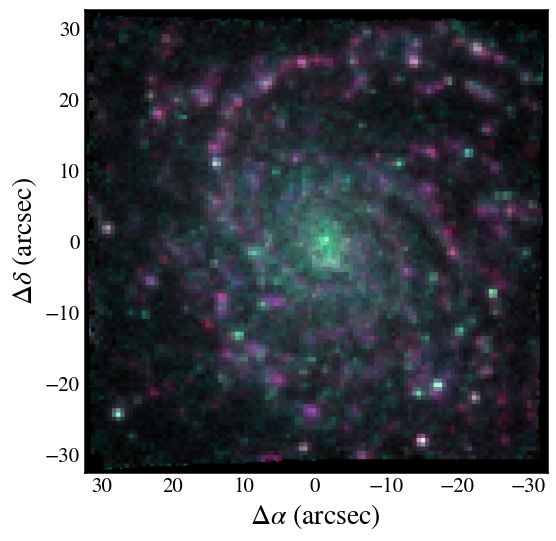

In [57]:
plt.imshow(rgb, origin='lower', extent=[32.4, -32.6,-32.4, 32.6])
plt.xlabel(r"$\Delta \alpha$ (arcsec)")
plt.ylabel(r"$\Delta \delta$ (arcsec)")

In [169]:
flux = cube['FLUX'].data
wave = cube['WAVE'].data

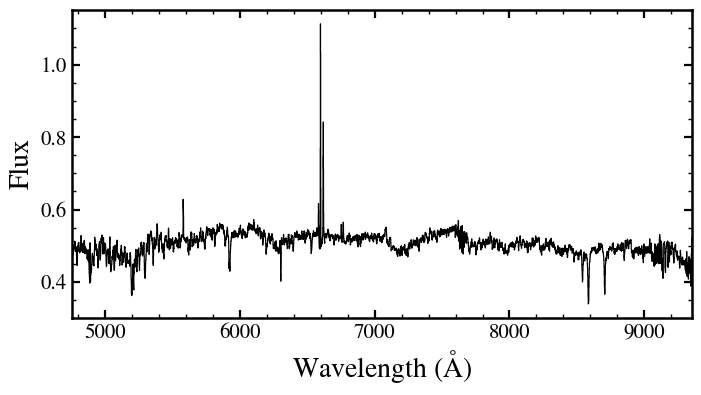

In [190]:
flux1d = flux[:,150,150]
plt.figure(figsize=(8,4))
plt.plot(wave,flux1d,drawstyle='steps-mid',color='k',linewidth=0.85)
plt.xlabel(r'Wavelength $\left( \mathrm{\AA} \right)$')
plt.ylabel('Flux')
#plt.text(r'Flux $\left( \mathrm{10^{-17}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1}\ spaxel^{-1}} \right)$')
plt.xlim(wave.min(),wave.max())
plt.savefig(f"{fig_out}spectrum.pdf",bbox_inches='tight')
plt.show()

In [699]:
whitelight = np.median(flux,axis=0)

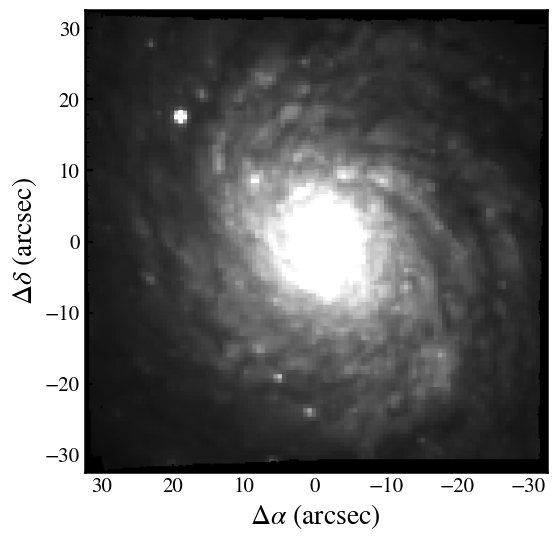

In [722]:
extent = [32.4, -32.6,-32.4, 32.6]

plt.imshow(whitelight,origin='lower',cmap='gray',vmin=0,vmax=np.median(whitelight)+2.5*np.std(whitelight),
          extent=extent)
#plt.axis('off')
plt.ylabel(r"$\Delta \delta$ (arcsec)",fontsize=20)
plt.xlabel(r"$\Delta \alpha$ (arcsec)",fontsize=20)
plt.savefig(f"{fig_out}-whitelight.pdf",bbox_inches='tight')
plt.show()

# Na D ISM EW

In [48]:
binid = cube['BINID'].data[0]
stellar_vel = Map['STELLAR_VEL'].data
waves = cube['WAVE'].data
model = cube['MODEL'].data
ivar = cube['IVAR'].data
flux = cube['FLUX'].data

In [49]:
inds = np.where(binid == 1000)

In [50]:
flux1d = np.median(flux[:,inds[0],inds[1]], axis=1)
ivar1d = np.median(ivar[:,inds[0],inds[1]], axis=1)
model1d = np.median(model[:,inds[0],inds[1]], axis=1)

sv = np.median(stellar_vel[inds[0],inds[1]])
c = 2.998e5
z = ((sv * (1+redshift))/c + redshift)
restwav = waves / (1+z)

In [51]:
sigma1d = 1 / np.sqrt(ivar1d)

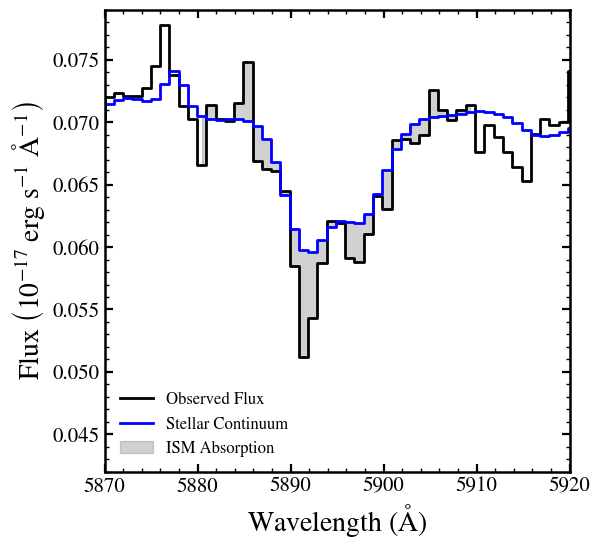

In [52]:
plt.plot(restwav,flux1d,color='k',drawstyle='steps-mid',label="Observed Flux")
plt.plot(restwav,model1d,color='blue',drawstyle='steps-mid',label="Stellar Continuum")
plt.plot(restwav,sigma1d,color='dimgray')

window = (restwav >= 5880) & (restwav <= 5910)

plt.fill_between(restwav,model1d,flux1d, window, color='dimgray', alpha=0.3, step="mid", label='ISM Absorption')

plt.xlim(5870,5920)
plt.ylim(0.042,.079)
plt.legend(frameon=False, fontsize='large')

plt.xlabel(r"Wavelength $\left( \mathrm{\AA} \right)$")
plt.ylabel(r"Flux $\left( \mathrm{10^{-17}\ erg\ s^{-1}\ \AA ^{-1}} \right)$")
#plt.ylabel("Normalized Flux")
plt.savefig(f"{fig_out}-NaD_window.pdf",bbox_inches='tight',dpi=300)
plt.show()

# Dap Maps

In [191]:
galname = "NGC4030"
datadict = get_datapaths(galname)

/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config has more than one config file:
 ['/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config/mangadap-1-1-LINCUBE-NGC4030.ini', '/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config/test.ini', '/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config/test_clean.ini']
Defaulting to /Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config/mangadap-1-1-LINCUBE-NGC4030.ini
Setting figure output path to paper-plots/NGC4030/


In [192]:
config_fil = datadict['config'][0]
cubefil = datadict['logcube'][0]
mapfil = datadict['maps'][0]
    
config = configparser.ConfigParser()
parsing = True
while parsing:
    try:
        config.read(config_fil)
        parsing = False
    except configparser.Error as e:
        print(f"Error parsing file: {e}")
        print(f"Cleaning {config_fil}")
        clean_ini_file(config_fil, overwrite=True)


redshift = float(config['default']['z'])
print(f"Redshift z={redshift} found in {config_fil}.")
cube = fits.open(cubefil)
Map = fits.open(mapfil)

Redshift z=0.00489 found in /Users/apitts4030/Repo/NaI_analysis/data/NGC4030/config/mangadap-1-1-LINCUBE-NGC4030.ini.


In [193]:
binid = cube['BINID'].data[0]

flux = cube['FLUX'].data
mask = cube['MASK'].data.astype(bool)
model = cube['MODEL'].data
modmask = cube['MODEL_MASK'].data.astype(bool)

maskcomb = np.logical_or(mask,modmask)

stellar_vel = Map['STELLAR_VEL'].data
stellar_vel_mask = Map['STELLAR_VEL_MASK'].data


stellar_sigma = Map['STELLAR_SIGMA'].data
stellar_sigma_mask = Map['STELLAR_SIGMA_MASK'].data
stellar_sigma_corr = Map['STELLAR_SIGMACORR'].data[0]
stellar_sigma = stellar_sigma - stellar_sigma_corr

chisq = Map['STELLAR_FOM'].data[2]

ivar = cube['IVAR'].data
var = 1/ivar
unc = np.sqrt(var)
SNR = Map['SPX_SNR'].data
ha = Map['EMLINE_GFLUX'].data[23]
ha_mask = Map['EMLINE_GFLUX_MASK'].data[23]

extent = [32.4, -32.6,-32.4, 32.6]

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_84382/3832300537.py:22: RuntimeWarning: divide by zero encountered in divide
  var = 1/ivar


In [194]:
# whitelight
whitelight = np.median(flux,axis=0)
whitelight[whitelight==0] = np.nan
# stellar velocity
w = (stellar_vel >= np.median(stellar_vel) - 4 * np.std(stellar_vel)) & (stellar_vel <= np.median(stellar_vel) + 4*np.std(stellar_vel))
stellar_vel[~w] = np.nan
w = stellar_vel_mask != 0
stellar_vel[w] = np.nan
# stellar sigma
w = (stellar_sigma >= np.median(stellar_sigma) - 4 * np.std(stellar_sigma)) & (stellar_sigma <= np.median(stellar_sigma) + 4*np.std(stellar_sigma))
stellar_sigma[~w] = np.nan
stellar_sigma[stellar_sigma==0] = np.nan
w = stellar_sigma_mask != 0
stellar_sigma[w] = np.nan
# H alpha
ha[ha==0] = np.nan
w = ha_mask != 0
ha[w] = np.nan

# chisq
chisq[chisq==0] = np.nan
#chisq -= np.min(chisq[np.isfinite(chisq)])

In [197]:
vbounds = {}
vbounds['NGC0289'] = ([0, -215, 0], [.6, 215, 15])
vbounds['NGC1084'] = ([0, -215, 0], [.6, 215, 15])
vbounds['NGC1097'] = ([0, -250, 0], [4, 250, 20])
vbounds['NGC1483'] = ([0, -150, 0], [.1, 150, 5])
vbounds['NGC4030'] = ([0, -250, 0], [0.5, 250, 10])

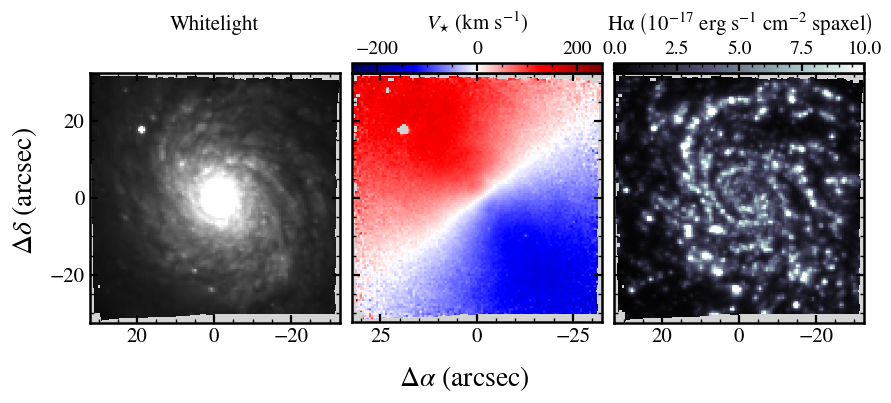

In [198]:
datalist = [whitelight, stellar_vel, ha]
cmaplist = ['gray','seismic', 'bone']

vmin, vmax = vbounds[galname]
labellist = ["Whitelight", r"$V_{\star}\ \left( \mathrm{km\ s^{-1}} \right)$",  
             r"$\mathrm{H \alpha}\ \left( \mathrm{10^{-17}\ erg\ s^{-1}\ cm^{-2}\ spaxel} \right) $"]

l = len(datalist)
fig, ax = plt.subplots(1,l,sharey=True,figsize=(10,4))

for i in range(l):
    data = datalist[i]
    cmap = cmaplist[i]
    label = labellist[i]

    im = ax[i].imshow(data, origin='lower', cmap=cmap, extent=extent, vmin=vmin[i], vmax=vmax[i])
    ax[i].set_facecolor('lightgray')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0)

    if i==0:
        """transparent_cmap = mcolors.ListedColormap(['none'])
        transparent_norm = mcolors.Normalize(vmin=0, vmax=1)
        
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', cmap=transparent_cmap, norm=transparent_norm)"""
        dummy_data = np.zeros(data.shape)
        dummy_cmap = mcolors.ListedColormap(['none'])  # Invisible color
        dummy_norm = mcolors.Normalize(vmin=0, vmax=1)

        # Create a colorbar with dummy data
        cbar = fig.colorbar(plt.imshow(dummy_data, cmap=dummy_cmap, norm=dummy_norm), cax=cax, orientation='horizontal')

        cbar.ax.set_facecolor('white')
        cbar.set_ticks([])
        cbar.set_label('')
        cbar.outline.set_visible(False)
        cbar.ax.patch.set_alpha(0)
        continue

    else:
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(label,fontsize=15,labelpad=-45)
        cax.xaxis.set_ticks_position('top')

ax[0].set_aspect(1)



fig.text(0.06,0.5,r"$\Delta \delta$ (arcsec)",ha="center", va="center", rotation='vertical',fontsize=20)
fig.text(0.5,0.03,r"$\Delta \alpha$ (arcsec)", va="center",ha="center",fontsize=20)
fig.text(0.5,1.19, "Whitelight", ha='center',va='center',fontsize=15,transform=ax[0].transAxes)

fig.subplots_adjust(wspace=0.05)
outstr = os.path.join(fig_out, f"{galname}-DAPMaps.pdf")
plt.savefig(outstr, bbox_inches='tight')

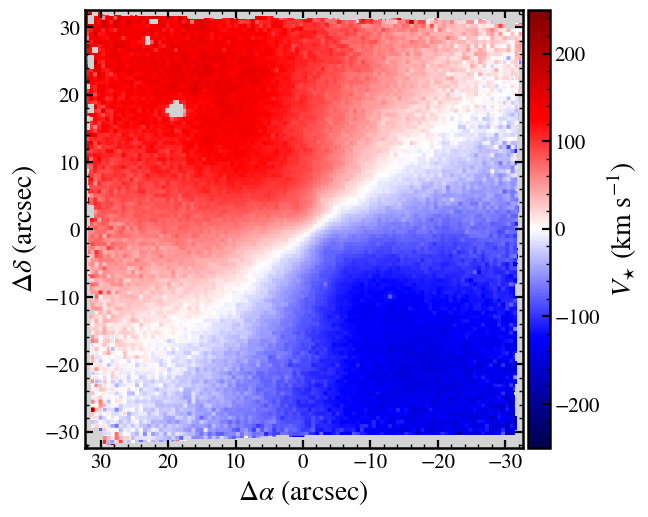

In [717]:
plt.figure()
im = plt.imshow(stellar_vel, cmap='seismic', origin='lower', extent=extent,
          vmin=-250, vmax=250)
plt.ylabel(r"$\Delta \delta$ (arcsec)",fontsize=20)
plt.xlabel(r"$\Delta \alpha$ (arcsec)",fontsize=20)

ax = plt.gca()
ax.set_facecolor('lightgray')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,cax=cax,label=r"$V_{\star}\ \left( \mathrm{km\ s^{-1}} \right)$")


plt.savefig(f"{fig_out}-Stellar_velocity.pdf",bbox_inches='tight')
plt.show()

# galaxy population

In [1]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

In [2]:
from astropy.io import ascii

In [6]:
sdssfil = "dat/galSpecExtra-dr8.fits"
madfil = "dat/MAD_sample.dat"

mpajhu = fits.open(sdssfil)[1].data
sdssind = (mpajhu['LGM_TOT_P50'] > 5.0) & (mpajhu['SFR_TOT_P50'] > -10.0)

In [7]:
mad = ascii.read(madfil)
madlogMstar = mad['col6']
madlogSFR = np.log10(mad['col7'])

In [8]:
outfil = "paper-plots/fig_sfrM_MAD.pdf"

In [20]:
custcolorscale = [
    [0, 'rgba(255, 255, 255, 0)'],   # Low density: light grey/transparent
    [0.1, 'rgba(240, 240, 240, 0.5)'],
    [0.3, 'rgba(200, 200, 200, 0.7)'],
    [0.6, 'rgba(100, 100, 100, 0.9)'],
    [1, 'rgba(0, 0, 0, 1)']          # High density: dark grey/black
]

In [28]:
x_minor_ticks = np.arange(8.4, 12.1, 0.1)  # Example minor ticks range
y_minor_ticks = np.arange(-2.1, 1.6, 0.1)  # Example minor ticks range

In [37]:
trace1 = go.Histogram2dContour(
    x=mpajhu['LGM_TOT_P50'][sdssind], y=mpajhu['SFR_TOT_P50'][sdssind], name='SDSS (Brinchmann et al. 2004)', ncontours=42,
    colorscale='Greys', reversescale=False, showscale=False
    )

trace3 = go.Scatter(
    x=madlogMstar, y=madlogSFR, mode='markers', name='MUSE Atlas of Disks',
    marker=dict(size=6, color='magenta', symbol='diamond'))

data = [trace1, trace3]


xdict=dict(
            showgrid=True,  # Minor grid lines
            ticklen=3,  # Minor tick length
            tickcolor='black',  # Minor tick color
            tickvals=x_minor_ticks.tolist(),  # Custom minor ticks position
            ticks='inside'  # Ensure minor ticks are inside
        )

ydict =dict(
            showgrid=True,  # Minor grid lines
            ticklen=3,  # Minor tick length
            tickcolor='black',  # Minor tick color
            tickvals=y_minor_ticks.tolist(),  # Custom minor ticks position
            ticks='inside'  # Ensure minor ticks are inside
        )

layout = go.Layout(showlegend=True, autosize=False, width=600, height=550,
                    legend=dict(x=0,y=1,font=dict(size=18, color='black', family='Times New Roman'),bgcolor='rgba(0,0,0,0)'),
                    annotations=[dict(x=0.5, y=-0.15, showarrow=False, text=r'$\log M_{*}/M_{\odot}$', xref='paper', yref='paper',
                                          font=dict(size=40, color='black')),
                                     dict(x=-0.18, y=0.5, showarrow=False, text=r'$\log \mathrm{SFR}/[M_{\odot}\mathrm{yr}^{-1}]$)',
                                              xref='paper', yref='paper', textangle=-90, 
                                              font=dict(size=40, color='black'))],
                   xaxis=dict(range=[8.4,12], domain=[0,1.0],
                              showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror='all',
                              #titlefont=dict(color='black', size=20, family='Times New Roman'),
                              ticks='inside', tickmode='auto', ticklen=6, tickfont=dict(color='black', size=20, family='Times New Roman'),
                             #minor=dict(showgrid=True, ticklen=4, nticks=10)
                              minor=xdict
                             ),
                   yaxis=dict(range=[-2.1,1.5], domain=[0,1.0],
                              showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror='all',
                              #titlefont=dict(color='black', size=20, family='Times New Roman'),
                              ticks='inside', tickmode='auto', ticklen=6, tickfont=dict(color='black', size=20, family='Times New Roman'),
                             #minor=dict(showgrid=True, ticklen=4, nticks=10)
                              minor=ydict
                             )
                  )


fig = go.Figure(data=data, layout=layout)

pio.write_image(fig, outfil)  